# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [4]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 218kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


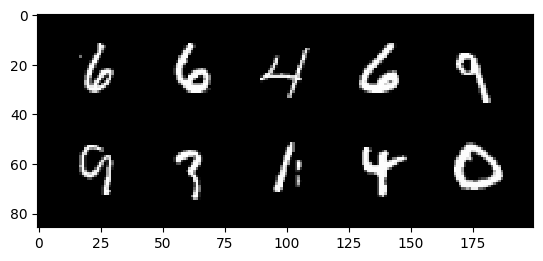

In [5]:
visualize_images(train_dataloader)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [7]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.517983750771668
Epoch 1: Loss=0.47505290124375943
Epoch 2: Loss=0.2748826815415237
Epoch 3: Loss=0.20775198001982803
Epoch 4: Loss=0.1730897194248135
Epoch 5: Loss=0.1483325948149471
Epoch 6: Loss=0.130976719118781
Epoch 7: Loss=0.11966942616943586
Epoch 8: Loss=0.10897281778565908
Epoch 9: Loss=0.1017948656769122
Test set: Avg. loss: 0.0935, Accuracy: 9713/10000 (97%)


(0.09347725524902344, tensor(97.1300))

## CIFAR10

In [8]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

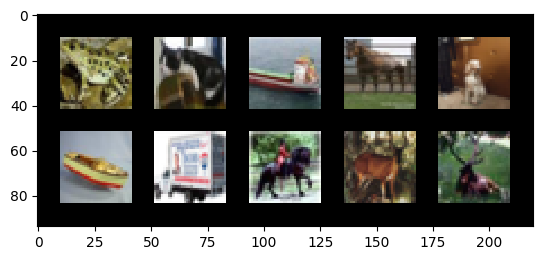

In [ ]:
visualize_images(train_dataloader)

In [ ]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

RuntimeError: ignored

The above failed! We have to make modifications to the model and perform the same training loop.

Modify the previous CNN code: [0.25 points]
- Hint 1: What difference can you notice with the MNIST images?
- Hint 2: How many pixels are the CIFAR10 images?

In [ ]:
# YOUR CODE HERE

#class CifarCNN(nn.Module):

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [ ]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Modify the fit function to also use a validation set

In [ ]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

In [ ]:
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

Epoch 0: Train Loss=1.4707, Validation Loss=0.8609, Validation acc=73.5300
Epoch 1: Train Loss=0.4312, Validation Loss=0.3087, Validation acc=91.1300
Epoch 2: Train Loss=0.2665, Validation Loss=0.2326, Validation acc=93.3700
Epoch 3: Train Loss=0.2050, Validation Loss=0.2042, Validation acc=94.0200
Epoch 4: Train Loss=0.1725, Validation Loss=0.1764, Validation acc=94.6800
Epoch 5: Train Loss=0.1529, Validation Loss=0.1530, Validation acc=95.4600
Epoch 6: Train Loss=0.1368, Validation Loss=0.1409, Validation acc=95.7600
Epoch 7: Train Loss=0.1237, Validation Loss=0.1246, Validation acc=96.3900
Epoch 8: Train Loss=0.1145, Validation Loss=0.1179, Validation acc=96.6400
Epoch 9: Train Loss=0.1055, Validation Loss=0.1110, Validation acc=96.7600
Test set: Avg. loss: 0.0930, Accuracy: 9719/10000 (97%)


(0.0930219783782959, tensor(97.1900, device='cuda:0'))

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

Epoch 0: Train Loss=2.3010, Validation Loss=2.2993, Validation acc=13.1600
Epoch 1: Train Loss=2.2982, Validation Loss=2.2966, Validation acc=13.5500
Epoch 2: Train Loss=2.2955, Validation Loss=2.2939, Validation acc=13.9000
Epoch 3: Train Loss=2.2927, Validation Loss=2.2911, Validation acc=14.9700
Epoch 4: Train Loss=2.2900, Validation Loss=2.2883, Validation acc=16.7700
Epoch 5: Train Loss=2.2871, Validation Loss=2.2855, Validation acc=18.9400
Epoch 6: Train Loss=2.2842, Validation Loss=2.2825, Validation acc=21.6500
Epoch 7: Train Loss=2.2812, Validation Loss=2.2795, Validation acc=24.4000
Epoch 8: Train Loss=2.2782, Validation Loss=2.2764, Validation acc=27.4600
Epoch 9: Train Loss=2.2749, Validation Loss=2.2731, Validation acc=30.4800
Test set: Avg. loss: 2.2730, Accuracy: 3140/10000 (31%)


Text(0, 0.5, 'Train loss')

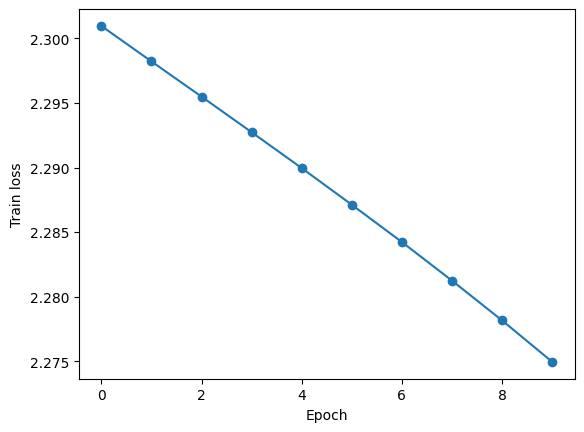

In [ ]:
cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitative) what happens. [0.5 points]

In [ ]:
# YOUR CODE GOES HERE



In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



Implement momentum and compute the learning curve [0.25 points]

In [ ]:
cnn = CNN().to(DEVICE)

# YOUR CODE GOES HERE
# optimizer =

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perfrom a grid search; define a list of choices for each hyperparameter and search over all combinations.

In [ ]:
# Perform a grid search over 2 values of learning rate and 2 values of Batch size.

from itertools import product

LR_GRID = [0.01, 0.1]
BS_GRID = [256, 512]

# YOUR CODE GOES HERE


In [ ]:
# Evaluate the performance on the test set with the best model!
predict(model=models[3], test_dataloader=test_dataloader, device=DEVICE)